# Aim: To classify images of only ships from a collection of satellite images
- ### Algorithm : Neural Network
- ### Framework: Tensorflow

## Steps Involved:
- ### 1.Install Libraries
- ### 2.Load Data
- ### 3.Split data into train and test
- ### 4.Building a Neural Network
- ### 5.Running the final model
- ### 5.Model Performance 



### 1.Install Libraries

In [4]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import tensorflow as tf
from tensorflow.python.framework import ops
import math
import matplotlib.pyplot as plt

%config IPCompleter.greedy=True

### 2.Load Data

In [5]:
f=open("shipsnet.json")
dataset = json.load(f)
f.close()
X = np.array(dataset['data']).astype('float')
Y = np.array(dataset['labels']).astype('uint8')




### 3.Split into Train and Test

In [6]:
#standardize the values
X=X/255

#test train split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1,random_state=54)


#reshaping
x_train=x_train.T
x_test=x_test.T
y_train=y_train.reshape((1,len(y_train)))
y_test=y_test.reshape((1,len(y_test)))

print ("number of training examples = " + str(x_train.shape[1]))
print ("number of test examples = " + str(x_test.shape[1]))
print ("X_train shape: " + str(x_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(x_test.shape))
print ("Y_test shape: " + str(y_test.shape))



number of training examples = 3600
number of test examples = 400
X_train shape: (19200, 3600)
Y_train shape: (1, 3600)
X_test shape: (19200, 400)
Y_test shape: (1, 400)



### 4. Building a Neural Network
- Layers : 2 hidden layers, 1 Output layer
- Optimiser : Adam Optimiser
- Regularisation : L2 Regularisation



#### 4.1Create Placeholders

In [7]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px *3=19200)
    n_y -- scalar, number of classes
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32,shape=[n_x,None])
    Y = tf.placeholder(tf.float32,shape=[n_y,None])

    
    return X, Y

#### 4.2 Intialise Parameters



In [8]:
def initialize_parameters(layers_dim):
    
    
    """
    layers_dim=[19220,25,12,1]
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25,19200 ]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [1, 12]
                        b3 : [1, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours

    W1 = tf.get_variable("W1", [layers_dim[1],layers_dim[0]], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [layers_dim[1],1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [layers_dim[2],layers_dim[1]], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [layers_dim[2],1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [layers_dim[3],layers_dim[2]], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [layers_dim[3],1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

#### 4.3 Forward Propagation

In [9]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> Sigmoid
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
         
    Z1 = tf.add(tf.matmul(W1,X),b1)                        
    A1 = tf.nn.relu(Z1) 
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                             
    A2 = tf.nn.relu(Z2) 
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                              

    
    return Z3

#### 4.4 Cost without Penality

In [10]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (1, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.sigmoid_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=labels))
 
    
    return cost

#### 4.5 Minibatches

In [11]:
def random_mini_batches(X, Y, mini_batch_size , seed = 54):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### 5.Final Model
- 2 Hidden layers with Relu Activation
- Output Layer with Sigmoid Activation
- Minibatch Size=64
- Learning rate = 0.0001

In [12]:
def model(X_train, Y_train, X_test, Y_test, layers_dim=[19200,4,4,1],learning_rate = 0.0001,
          num_epochs =1500,minibatch_size=64,print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->Sigmoid.
    
    Arguments:
    X_train -- training set, of shape (input size = 19200, number of training examples = 3600)
    Y_train -- test set, of shape (output size = 1, number of training examples = 3600)
    X_test -- training set, of shape (input size = 19200, number of training examples = 400)
    Y_test -- test set, of shape (output size = 1, number of test examples = 400)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y= create_placeholders(n_x,n_y)

    # Initialize parameters
    parameters = initialize_parameters(layers_dim)

    
    # Forward propagation: Build the forward propagation in the tensorflow graph
 
    Z3 = forward_propagation(X,parameters)
    
    # Cost function: Add cost function to tensorflow graph

    cost = compute_cost(Z3,Y)
    
    #Regularisation Penality
    vars = tf.trainable_variables() 
    lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in vars if 'b' not in v.name ]) * 0.01

    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.

    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost+lossL2)

    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
     
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
            
                _ ,_, minibatch_cost = sess.run([optimizer, lossL2,cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                
                epoch_cost += minibatch_cost / num_minibatches
        
        
        # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
       # Calculate the correct predictions
        predicted=tf.round(tf.nn.sigmoid(Z3))
        
        correct_prediction = tf.equal(predicted, Y)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        predictions_train = predicted.eval({X: X_train, Y: Y_train})
        predictions_test = predicted.eval({X: X_test, Y: Y_test})
        
        
    
        return predictions_train,predictions_test


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Cost after epoch 0: 0.534043
Cost after epoch 100: 0.214606
Cost after epoch 200: 0.150122
Cost after epoch 300: 0.110029
Cost after epoch 400: 0.080196
Cost after epoch 500: 0.065888
Cost after epoch 600: 0.071202
Cost after epoch 700: 0.058570
Cost after epoch 800: 0.050558
Cost after epoch 900: 0.053900
Cost after epoch 1000: 0.047157
Cost after epoch 1100: 0.047899
Cost after epoch 1200: 0.042709
Cost after epoch 1300: 0.048070
Cost after epoch 1400: 0.040495


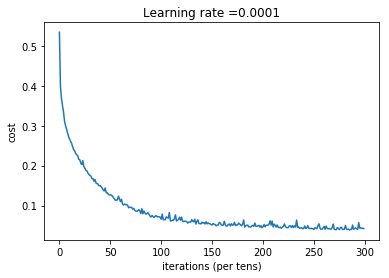

Parameters have been trained!


In [13]:
predictions_train,predictions_test = model(x_train, y_train, x_test, y_test)

### 6.Model Performance
- Accuracy
- Precision
- Recall
- F1-Score


In [14]:
precision_train, recall_train,f1_score_train,_= precision_recall_fscore_support(y_train, predictions_train, average='micro')
precision_test, recall_test,f1_score_test,_   = precision_recall_fscore_support(y_test, predictions_test, average='micro')
accuracy_train = accuracy_score(y_train[0],predictions_train[0])
accuracy_test = accuracy_score(y_test[0],predictions_test[0])

print("Train Performance")
print ("Train Accuracy:", accuracy_train)
print ("Precision_train:", precision_train)
print ("recall_train:", recall_train)
print ("f1_score_train:", f1_score_train)
print("")

print("Test Performance")
print ("Test Accuracy:",accuracy_test)
print ("Precision_test:", precision_test)
print ("Recall_test:", recall_test)
print ("f1_score_test:", f1_score_test)


Train Performance
('Train Accuracy:', 0.99638888888888888)
('Precision_train:', 0.98789878987898794)
('recall_train:', 0.99777777777777776)
('f1_score_train:', 0.9928137092316196)

Test Performance
('Test Accuracy:', 0.93999999999999995)
('Precision_test:', 0.8392857142857143)
('Recall_test:', 0.93999999999999995)
('f1_score_test:', 0.88679245283018859)
